In [1]:
#setup
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats.stats import pearsonr

In [2]:
#read data
data = pd.read_csv("obt_slim.csv")

/var/folders/f4/gmbjrwrj2llb8qgk7x9xssxr0000gp/T/ipykernel_20731/3860814092.py:2: DtypeWarning: Columns (6,10,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("obt_slim.csv")


# SDOH Explore
We are interested in these sdoh variables: 

summary scores = [`series_themes_sum`,`socioeconomic_status_sum`,`hh_characteristics_sum`,`minority_status_sum`,`housing_status_sum`]

percentiles = [`overall_percentile_ranking`,`socioeconomic_status_percentile_rank`,`hh_characteristics_percentile_rank`,`minority_status_percentile_rank`,`housing_status_percentile_rank`]

`series_themes_sum` and `overall_percentile_ranking` are aggregate social vulnerability index (SVI) measures across the four specific categories: socioeconomic status, household characteristics (`hh_characteristics`), minority status, and housing status)

In [3]:
sdoh_summary_scores = ['series_themes_sum',"socioeconomic_status_sum","hh_characteristics_sum","minority_status_sum","housing_status_sum"]
sdoh_percentiles = ["overall_percentile_ranking","socioeconomic_status_percentile_rank","hh_characteristics_percentile_rank","minority_status_percentile_rank","housing_status_percentile_rank"]

In [4]:
#subsetting data for sdoh measures only
sdoh = data[sdoh_summary_scores+sdoh_percentiles]
#descriptive stats of each sdoh measure
sdoh.describe()

,series_themes_sum,socioeconomic_status_sum,hh_characteristics_sum,minority_status_sum,housing_status_sum,overall_percentile_ranking,socioeconomic_status_percentile_rank,hh_characteristics_percentile_rank,minority_status_percentile_rank,housing_status_percentile_rank
count,12411.000000,12411.000000,12411.000000,12411.000000,12411.000000,12411.000000,12411.000000,12411.000000,12411.000000,12411.000000
mean,8.372298,2.591571,2.462508,0.628408,2.689810,0.568111,0.531156,0.502355,0.628408,0.598359
std,1.864137,0.951480,0.511875,0.272884,0.589177,0.271503,0.278598,0.273460,0.272884,0.263138
min,2.868300,0.215100,0.296100,0.001000,0.796800,0.002500,0.001300,0.000000,0.001000,0.008300
25%,7.040100,1.861600,2.122200,0.430000,2.313900,0.344400,0.290900,0.276250,0.430000,0.398500
50%,8.523900,2.655700,2.469800,0.676300,2.766700,0.603100,0.547400,0.508600,0.676300,0.644500
75%,9.755700,3.331900,2.833150,0.871100,3.126100,0.800400,0.772800,0.737900,0.871100,0.824450
max,13.245600,4.747300,4.136200,1.000000,4.356800,1.000000,1.000000,0.999700,1.000000,0.999700


<AxesSubplot:xlabel='series_themes_sum', ylabel='Count'>

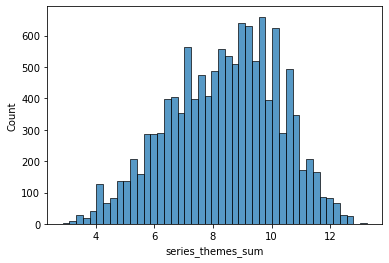

In [5]:
#histogram of overall sdoh summary score
sns.histplot(data = sdoh, x = "series_themes_sum")

Overall SDOH summary score (`series_themes_sum`) is roughly normally distributed, percentile scores will not be. Going to focus on only summary scores for simplicity.

In [6]:
#mean centering summary variables
#create function to center data
center_function = lambda x: x - x.mean()

#apply function to original NumPy array
sdoh_summary_centered = center_function(sdoh[sdoh_summary_scores])

#view mean centered data
sdoh_summary_centered.head()

,series_themes_sum,socioeconomic_status_sum,hh_characteristics_sum,minority_status_sum,housing_status_sum
0,0.714302,0.764329,0.237292,0.099192,-0.38651
1,0.714302,0.764329,0.237292,0.099192,-0.38651
2,0.714302,0.764329,0.237292,0.099192,-0.38651
3,0.266102,0.358429,0.704592,-0.087708,-0.70921
4,0.266102,0.358429,0.704592,-0.087708,-0.70921


<AxesSubplot:>

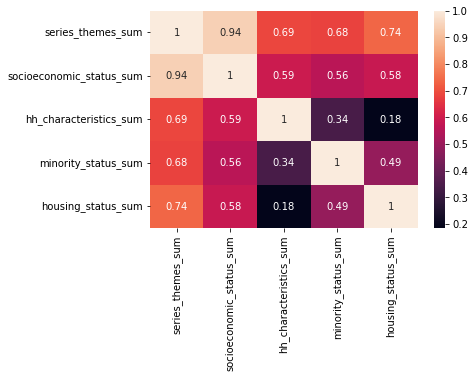

In [7]:
#relationship between sdoh measures
sns.heatmap(sdoh_summary_centered.corr(),annot=True)

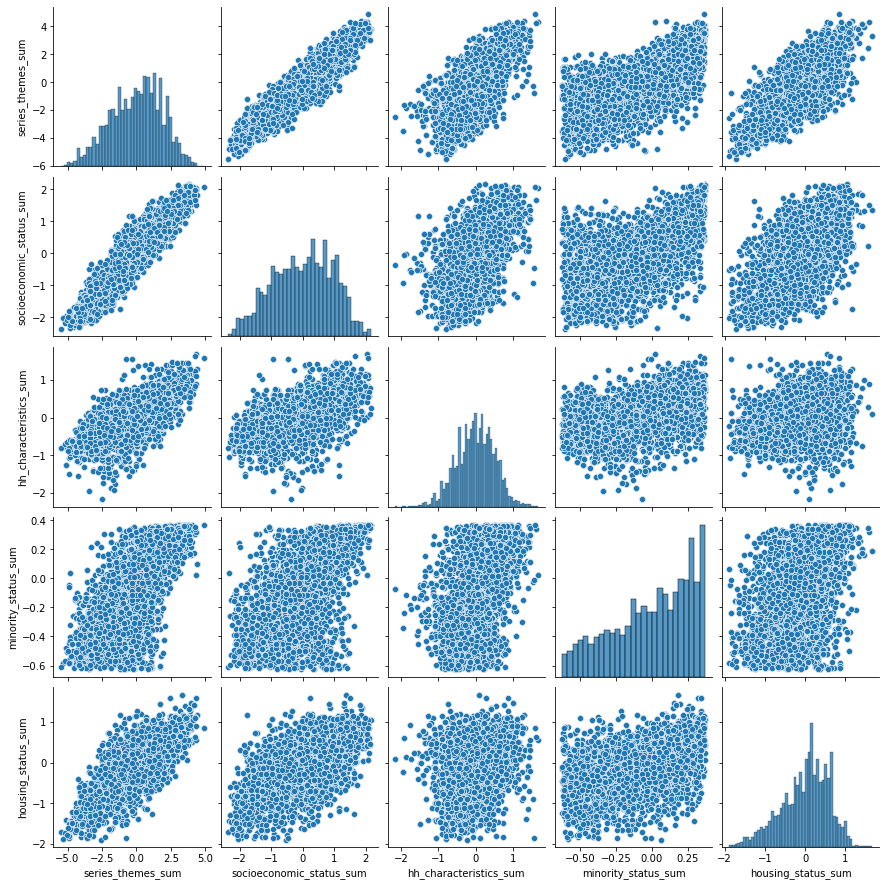

In [8]:
sns.pairplot(data = sdoh_summary_centered)

Overall sdoh summary score is most strongly correlated with socioeconomic status, then housing status, then household characteristics, and lastly minority status.

Minority status and housing status summary scores are not normally distributed.

# Relating SDOH and Readmission Rates

In [9]:
#group by county and condition (we only have county level sdoh)
#aggregating sums of number_of_discharges and number_of_readmissions, but mean for overall sdoh sum measure
#predicted/expected readmission ratios are probably not helpful here we shouldn't aggregate over ratios

data_county = (data.groupby(['county_name','condition_name'], as_index=False)
       .agg({'number_of_discharges':'sum', 'number_of_readmissions':'sum','series_themes_sum':'mean'})
       .rename(columns={'Missed':'Sum1', 'Credit':'Sum2','Grade':'Average'}))
data_county.head()

,county_name,condition_name,number_of_discharges,number_of_readmissions,series_themes_sum
0,ABBEVILLE,Heart Failure,0.0,0.0,9.9908
1,ABBEVILLE,Pneumonia,0.0,0.0,9.9908
2,ACADIA,Chronic Obstructive Pulmonary Disease,67.0,11.0,10.5306
3,ACADIA,Heart Failure,64.0,11.0,10.5306
4,ACADIA,Pneumonia,140.0,24.0,10.5306


In [10]:
#add calculated raw_readmission_rate
data_county["raw_readmission_rate"] = data_county.number_of_readmissions / data_county.number_of_discharges * 100
data_county.head()

,county_name,condition_name,number_of_discharges,number_of_readmissions,series_themes_sum,raw_readmission_rate
0,ABBEVILLE,Heart Failure,0.0,0.0,9.9908,NaN
1,ABBEVILLE,Pneumonia,0.0,0.0,9.9908,NaN
2,ACADIA,Chronic Obstructive Pulmonary Disease,67.0,11.0,10.5306,16.417910
3,ACADIA,Heart Failure,64.0,11.0,10.5306,17.187500
4,ACADIA,Pneumonia,140.0,24.0,10.5306,17.142857


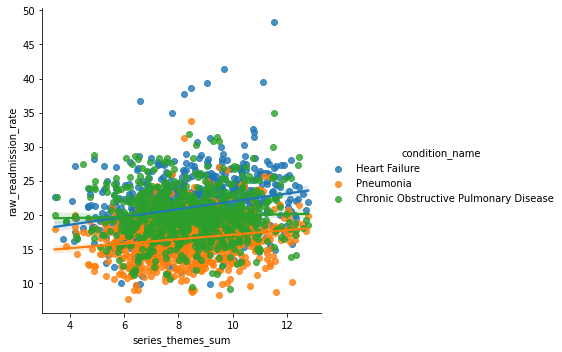

In [11]:
#plotting relationship between raw_readmission_rate, series_themes_sum, and condition_name
sns.lmplot(data = data_county, x = "series_themes_sum", y = "raw_readmission_rate",hue = "condition_name")

In [12]:
#TODO: calculate Rs and significance

#subset dataframe by condition
heart_failure = data_county.loc[data_county['condition_name'] == "Heart Failure"]
pneumonia = data_county.loc[data_county['condition_name'] == "Pneumonia"]
COPD = data_county.loc[data_county['condition_name'] == "Chronic Obstructive Pulmonary Disease"]

#calculate condition specific correlations
#pearsonr(heart_failure['series_themes_sum'],heart_failure['raw_readmission_rate'])